# <span id="chap_concepts_paths"></span> Paths, connectivity, and components

The nodes and edges form the topology of a network. Going back to Euler's approach to [modelling the K&ouml;nigsberg bridges](introduction.ipynb#sec_konigsberg), it's easy to consider nodes to be "places" in some sense, and edges to be "routes" between them. This suggests that we can think of a network like we think of a map, in which we can "be" at a given "place" and "move" to an "adjacent" place by traversing a "route". This "navigation" analogy is so compelling that we'll use such terms even for networks that have no link to geography.

## <span id="concepts_paths_paths"></span> Paths

We said before that the edges of a network define [adjacency](concepts-networks.ipynb#sec_concepts_networks_adjacency). Clearly there is a more general notion here, of the set of nodes adjacent to a node, and the set of nodes adjacent to any nodes in that set, and so forth.

The underlying idea here is that of a path. A *path* in a network is a sequence of adjacent nodes. If we label the nodes and edges in the network somehow, we can represent a path as a the starting node, a list of edges, and the ending node: the intermediate nodes are all defined by the fact that an edge connects two nodes. The *length* of the path is the number of edges it contains. (Adjacencies are therefore just paths of length one.)

A path might be between two different nodes *A* and *B*, or might in some special cases be a sequence of nodes that begin and end at the same node *A*, or perhaps be a more complex *self-intersecting* path that connects *A* to *B* but intersects with *A* in the process

<div class=figure id=fig_concepts_paths_types>
<div class=figurebody>
<img alt="Path types" src="concepts-paths.svg">
<br>
<span class=caption>Different types of paths</span>
</div>
</div>

In this figure, the simple path can be described as *A-a-b-c-B*, while the cycle is would be *A-a-b-d-A*, starting and finishing at node *A*. Both have length three. The self-intersecting path is a little more tricky. We could describe it as *A-a-b-d-e-f-b* (length 5), but we could equally go around the cycle twice to get a path *A-a-b-d-a-b-d-e-f-B* (of length 8), and so forth. (We could actually do the same thing for the cycle, constructign a cycle of length 6 as *A-a-b-d-a-b-d-A*.) The point is that, when we have cycles, we could "go around the cycle" as often as we want. By convention we usually choose the *shortest* path, going around any cycles only once, as the length of a self-intersecting path. 

## <span id="sec_concepts_paths_parallel"></span> Parallel edges and self loops

Suppose we have two nodes *A* and *B*, and two edges between them. This provides two "routes" by which we can navigate between the two nodes. The two edges are referred to as *parallel*: they have the same start and end points.

Parallel edges are needed in some network models, but as a general rule we try to exclude them for reasons of mathematical simplicity (which will become apparent later). A network is therefore often defined as having no parallel edges &ndash; or, to put it another way, there is only ever at most one edge between any pair of nodes.

It might happen that a node *A* has an edge that connects it to itself: *A* is both the start and end point for the edge. Such edges are called *self loops*. Again, self loops are sometimes important when modelling phenomena; and, again for reasons of simplicity, we often enforce that networks have no self loops, so all edges have distinct start and end points.

An undirected network with no parallel edges and no self-loops is sometimes called a *simple network*. Their mathematics is simpler, and they're still powerful enough to model a huge range of phenomena and applications. Most of the networks we look at in this book are simple (in this sense): simple, but complex.

## <span id="sec_concepts_paths_directedness"</span> Directedness

In the model above, edges are *undirected*, in the sense that one can traverse an edge in either direction. This is fine if edges represent a connection between two nodes that is in some sense symmetrical or bi-directional. If nodes represent people and edges represent the relationship "knows", then this is clearly the case: if *A* knows *B* then (presumably) *B* also knows *A*. It is sometimes useful to model relationships that are asymmetric, however: if edges represent "is an ancestor of", then one needs to know whether *A* is an ancestor of *B* or *vice versa*. The relationship represented by the edge is directional, and we capture this by saying that the edges are *directed*. We usually indicate this using an arrow pointing in the direction of the edge.

In terms of navigation, directed edges can only usually be traversed in the direction indicated by the arrow, respecting the direction of the edge. Directedness complicates navigation by forbidding some moves, and complicates the definition of connectedness through the possibility of having parts of the network that can reach all other parts while remaining unreachable themselves.

If a network is directed, there may be two edges betweena pair of nodes *A* and *B* that run in opposite directions. We regard edges as parallel in the sense of the [previous section](#sec_concepts_paths_parallel) if only if they have the same start and end points *and* the same direction.

## <span id="sec_concepts_paths_concectedness"></span> Connectedness and components

The first question we generally ask about navigation is: can we construct a path between any pair of nodes in the network? There are actually two questions combined into one here: is it possible *in principle* to build such a path?, and can we actually *find* such a path if we know one exists?

The first question deals with the *connectedness* of a network. A network is *connected* if there exists a path between every pair of nodes, and *disconnected* otherwise. A disconnected network is really just the same as two networks side by side, of course, but it sometimes makes sense to consider these two "independent" networks to be part of "the same" network. A good example is the street plan of Greater New York, which we might consider to be one big network but which is composed of several sub-networks disconnected by New York harbour into the street plan of Manhatten, the street plan of Staten Island, and so forth.

We refer to the parts of a network that are connected as the *components* of the network, and it is by definition possible to find a path between any pair of nodes within the same component. (And, also by definition, impossible to find a path between two nodes in different components.)

This brings us to the second question above &ndash; finding paths even when we know they exist &ndash; and this is, perhaps surprisingly, not a question that's always easily answered. In the mesh we've been considering, it's easy to see how to construct a path between any pair of nodes: go "across" the rows until the appropriate column, and then "up" (or "down") to the appropriate row. This is sometimes called *Manhatten routing*, and is an algorithm that will be familiar to anyone who's ever visited a major American city. It is probably most notable for *not* working in non-mesh-like cities such as are found in much of Europe (and in smaller, older, American towns &ndash; or indeed in the older parts of New York), where the network of streets is more complex.

In a network with a more complex structure, it will clearly be considerably harder to find a path. Put another way, an algorithm like Manhatten routing lets us define the path between two nodes, but there may not *be* an algorithm for other classes of network. Fortunately we often don't need to be able to find specific paths: it's enough to know that they exist (or don't) in principle &ndash; or even, sometimes, that they *probably* exist (or don't).

## <span id="sec_concepts_paths_shortest"></span> Diameters and shortest paths

Let's return to [paths](#concepts_paths_paths) in a more global sense. For any pair of nodes there will often be multiple paths between them, some longer and some shorter. The *shortest path* between two nodes is clearly of some significance: it's the "quickest route" between two points in the network. There may be several paths with the same length, in which case they would all be "shortest", but typically there is one that's shorter than the rest. By definition this path will not be self-intersecting, and will be the network equivalent of a "straight line" between the two nodes concerned.

In [24]:
import sys
sys.path.append('src')

import networkx as nx
import numpy as np

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import seaborn

from cncp import *

We can illustrate the idea of shortest paths using the mesh from earlier. `NetworkX` has a function that can compute the shortest path between any pair of nodes. Suppose we create a mesh again:

In [2]:
mesh = lattice_graph(9, 9)

The [function we defined earlier](concepts-networks.ipynb#sec_concepts_networks_lattice) labels the nodes sequentially from left to right and top to bottom: the north-west and south-east corner nodes of this network are labelled 0 and 80 respectively. We can therefore ask what is the shortest path between these two nodes:

In [20]:
shortest = nx.shortest_path(mesh,0, 80)
print "Shortest path is {s}".format(s = shortest)

Shortest path is [0, 1, 2, 11, 20, 21, 30, 39, 40, 49, 58, 67, 68, 69, 78, 79, 80]


This function actually returns the *nodes* occurring on a path, rather than the *edges*, since `NetworkX` doesn't require us to label edges. This means that the length of the path is one less than the number of nodes in the list returned by `shortest_path`:

In [21]:
print "Shortest path length is {l}".format(l = len(shortest) - 1)

Shortest path length is 16


A list of node labels isn't all that informative, but it's fairly easy to visualise this path by plotting the mesh and colouring the nodes on the path. To do this we use `matplotlib` to draw the mesh, but set the colours that'll be used for each node: 

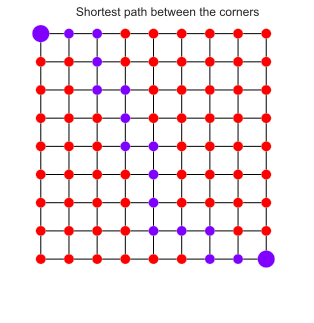

In [25]:
# set the colour for each node to be 0.25 or 0.75 depending on whether
# it is on the path or not
cols = [ 0.75 ] * mesh.order()
for i in shortest:
    cols[i] = 0.25
        
# set the node sizes, making the start and endpoints larger
sizes = [ 100 ] * mesh.order()
sizes[0] = sizes[-1] = 300

# colour map we'll use to show the path
colour_map = plt.cm.rainbow

# draw the mesh, colouring the nodes according to whether they're on the shortest path
fig = plt.figure(figsize = (5, 5))
ax1 = fig.gca()
_ = ax1.set_title("Shortest path between the corners")
_ = ax1.set_axis_off()
draw_lattice(mesh, ax = ax1, with_labels = False, node_size = sizes,
             node_color = cols, cmap = colour_map)
_ = ax1.set_xlim([-0.05, 1.05])
_ = ax1.set_ylim([-0.05, 1.05])
_ = plt.show()

A moment's thought should convince you that, in this case, the path shown is only *one* of the shortest paths between the corners: there are others with the same length. (If we want, `NetworkX` has a function `all_shortest_paths` that will find them all for us, returning a list of paths.)

The length of the shortest path is a local property, local to the pair of nodes involved. There is a global property here as well, though. If we compute the shortest paths between all pairs of nodes, then some of these paths will clearly be longer than others. The *longest shortest path* will therefore be the farthest distance (in terms of path length) between any pair of nodes in the network, and this is value is referred to as the *diameter* of the network. You can think of the diameter as the "longest straight line" between any two nodes in the network. `NetworkX` can calculate the diameter for us immediately:

In [19]:
print "Diameter of the mesh is {d}".format(d = nx.diameter(mesh))

Diameter of the mesh is 16


Unsurprisingly, the longest "straight line" in the mesh network is the "line" between the two corners. The diameter isn't the longest path, or even the longest simple path: the path "round the edges" is longer than the diameter. But the diameter measures the longest "irreducuble" path between two points, and so is a measure of the "width" of the network: hence it's name.